**Purpose**: The purpose of this notebook is to demonstrate how the data used in the RICHAI dataset is generated.

# Data generation process

In [1]:
import h5py 
import numpy as np 
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

# Part 1: Reading in the data

In [2]:
# data folder, data set, individual data file
data_folder = "/data/bvelghe/capstone2022/"
data_set = "A/"
file_path = "Run008548.EOSlist.CTRL.p.v2.0.4-01_f.v2.0.4-01.h5"

# read in 
f = h5py.File(os.path.join(data_folder, data_set, file_path))
f.keys()

<KeysViewHDF5 ['Events', 'HitMapping', 'Hits']>

In [3]:
events=f['Events']        # event data
hit_map=f['HitMapping']   # maps range of hits for each event
hits=f['Hits']            # pm hit data for each hit

## Event data

In [4]:
event = 0                        # first event
features = events.dtype.names    # features that each event has

In [5]:
print(f"Features for event: {event}")
for feat, value in zip(features, events[event]):
    print(f"{feat}: {value}")

Features for event: 0
run_id: 8548
burst_id: 1095
event_id: 11551
track_id: 0
track_momentum: 39.1020622253418
chod_time: 6.377106189727783
ring_radius: 184.6814727783203
ring_centre_pos: [-196.52412   -16.790398]
ring_likelihood: [5.2108949e-01 1.0000000e+00 3.3442233e-05]


## PM data

In [6]:
# pm information for each hit
pm_info = hits.dtype.names
pm_info

('disk_id', 'pmt_id', 'supercell_id', 'updowndisk_id', 'hit_time')

In [7]:
# hits array contains pm data for each event
# hit map tells us how to index hits array to get hits for each event
# hitmap[n] to hitmap[n+1] is the indexing for hits, where n = event #
event_pm_info = hits[hit_map[event]:hit_map[event+1]]
event_pm_info

array([(1, 7, 37, 1,   6.4918146), (1, 4, 41, 1,   6.334047 ),
       (1, 0, 41, 1,   6.0296416), (1, 6,  2, 0,   6.2478   ),
       (1, 3,  2, 0,   6.4438033), (1, 0,  2, 0,   6.271224 ),
       (1, 7, 26, 0, -28.139177 ), (1, 5, 10, 0,   6.3303947),
       (1, 1, 32, 0,   6.297724 ), (1, 4, 21, 0,   6.168077 ),
       (1, 2,  9, 0,   6.178306 ), (1, 5, 32, 0,   6.3656635),
       (1, 4, 26, 1,   7.366777 ), (1, 0, 26, 1,   7.8246713),
       (1, 0, 37, 1,   7.230756 ), (1, 0, 26, 0, -27.836351 ),
       (1, 0, 10, 0,   6.2184596), (1, 0, 32, 0,   5.7575994),
       (1, 0, 21, 0,   6.3124247), (1, 0,  9, 0,   6.40539  ),
       (1, 0,  2, 0,   5.7096343), (1, 0, 41, 1,   5.6795297)],
      dtype=[('disk_id', '<i4'), ('pmt_id', '<i4'), ('supercell_id', '<i4'), ('updowndisk_id', '<i4'), ('hit_time', '<f4')])

In [8]:
# this is how many hits event 1 recorded, it will be variable for each event
print(f"# of hits for event {event+1}: {len(event_pm_info)}")

# of hits for event 1: 22


In [9]:
# info for pm hit 1/22 for event 1
print(f"PM info for event: {event}")
for info, value in zip(pm_info, event_pm_info[0]):
    print(f"{info}: {value}")

PM info for event: 0
disk_id: 1
pmt_id: 7
supercell_id: 37
updowndisk_id: 1
hit_time: 6.491814613342285


## Mapping PM data to position map

Our position map file is saved as `rich_pmt_positions.dat` in the `RICHPID` repo in the `tools` folder.  Bob has provided a tool to parse this file to `npy` format.  To get this file one needs to run: `python conf_parser.py rich_pmt_positions.dat rich_pmt_positions.npy` in the `RICHPID/tools/` directory.

In [10]:
# this is our map of (x, y) locations that the light hits
position_map = np.load("/home/nico/RICHPID/tools/rich_pmt_positions.npy")
position_map.shape

(1952, 3)

In [11]:
# these are our coordinates for each position in the position map
coord = position_map[1]

# pm location (x, y, mirror)
print("First pm in position map")
print(f"x:\t {coord[0]}")
print(f"y:\t {coord[1]}")
print(f"mirror:\t {coord[2]}")

First pm in position map
x:	 -243.0
y:	 93.52999877929688
mirror:	 0.0


In [12]:
# We need this function provided by Bob to map the hits from our PM info for each event.
# Rakesh has an updated version of this

def compute_seq_id(disk_id, up_dw_id, sc_id, pm_id, or_id=0):
    """Compute the RICH PMT sequence ID"""
    if or_id < 1:
        seq_id = sc_id * 8 + pm_id + up_dw_id * 61 * 8 + disk_id * 61 * 8 * 2
    else:
        seq_id = 61 * 8 * 2 * 2 + sc_id + up_dw_id * 61 + disk_id * 61 * 2
    return seq_id

In [13]:
# this is the pm info for the first hit for the first event
single_hit_pm_info = event_pm_info[0]

# this computes which value in the pm position map the hit occured at
pm_map_location = compute_seq_id(
    disk_id=single_hit_pm_info["disk_id"],
    up_dw_id=single_hit_pm_info["updowndisk_id"],
    sc_id=single_hit_pm_info["supercell_id"],
    pm_id=single_hit_pm_info["pmt_id"],
)

print(f"This hit occured at idx {pm_map_location} in the position map")

This hit occured at idx 1767 in the position map


In [14]:
# therefore the (x, y, mirror) information for this hit is
# this means the first hit for the first event 
# hit mirror 1 at (-171, -93.53) location
position_map[pm_map_location]

array([-171.  ,  -93.53,    1.  ], dtype=float32)

## Getting all hit data for one event

In [15]:
hits = []

for pm_info in event_pm_info:
    pm_idx = (
        compute_seq_id(
            disk_id=pm_info["disk_id"],
            up_dw_id=pm_info["updowndisk_id"],
            sc_id=pm_info["supercell_id"],
            pm_id=pm_info["pmt_id"]
        )
    )
    
    hits.append(position_map[pm_idx])
    
hits = np.array(np.array(hits))

# these are our hit locations for first first event
# (x, y, mirror)
hits

array([[-171.  ,  -93.53,    1.  ],
       [   0.  , -171.47,    1.  ],
       [ -27.  , -187.06,    1.  ],
       [-153.  ,   93.53,    1.  ],
       [-162.  ,   77.94,    1.  ],
       [-171.  ,   62.35,    1.  ],
       [ -72.  ,  171.47,    1.  ],
       [ 189.  ,  -31.18,    1.  ],
       [ 180.  ,   46.77,    1.  ],
       [ 180.  ,   15.59,    1.  ],
       [ 180.  ,  -46.77,    1.  ],
       [ 162.  ,   77.94,    1.  ],
       [-171.  ,  -62.35,    1.  ],
       [-198.  ,  -77.94,    1.  ],
       [-207.  , -124.71,    1.  ],
       [-108.  ,  140.3 ,    1.  ],
       [ 189.  ,  -62.35,    1.  ],
       [ 162.  ,   46.77,    1.  ],
       [ 153.  ,    0.  ,    1.  ],
       [ 144.  ,  -46.77,    1.  ],
       [-171.  ,   62.35,    1.  ],
       [ -27.  , -187.06,    1.  ]], dtype=float32)

# Part 2: Some useful plots

### Distribution of hit times
- Theoretically the hit times should show one single peak

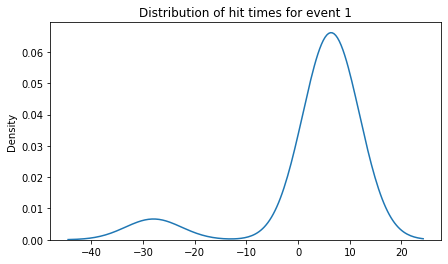

In [16]:
hit_times = []

# get all the hit time data for the first event
for pm_info in event_pm_info:
    hit_times.append(pm_info["hit_time"])

plt.figure(figsize=(7, 4))
sns.kdeplot(hit_times)
plt.title(f"Distribution of hit times for event {event+1}");

For this event, we can see below that the first two hits are very far away in time from the remaining hits, and are therefore noise.  Our ML algorithm will need to deal with this noise.  We can also identify this based on `chod_time`, since we want our hit times to be close to the `chod_time`.

In [17]:
sorted(hit_times)

[-28.139177,
 -27.836351,
 5.6795297,
 5.7096343,
 5.7575994,
 6.0296416,
 6.168077,
 6.178306,
 6.2184596,
 6.2478,
 6.271224,
 6.297724,
 6.3124247,
 6.3303947,
 6.334047,
 6.3656635,
 6.40539,
 6.4438033,
 6.4918146,
 7.230756,
 7.366777,
 7.8246713]

### CHOD time vs. Event Time
- We want event times to be close to CHOD time

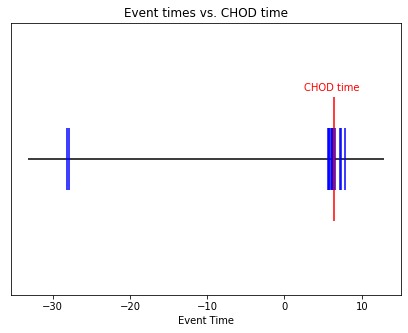

In [18]:
chod_time = events["chod_time"][0]

plt.figure(figsize=(7, 5))
plt.hlines(1,min(hit_times)-5,max(hit_times)+5, colors="black")  # Draw a horizontal line
plt.eventplot(hit_times, orientation='horizontal', colors='b')
plt.eventplot([chod_time], orientation='horizontal', colors='red', linelengths=2)
plt.text(2.5, 2.1, "CHOD time", color="red")
plt.title("Event times vs. CHOD time")
plt.xlabel("Event Time")
plt.yticks([])
plt.show()

### Ring plot

- Below we plot the pm array and the hits for the first event

In [19]:
# plotting function from Bob that plots the PMT array
def draw_pmt_pos(ax,pmt_pos):
    """
        Add circle patches corresponding to the PMT position to the Axes object ax
    """
    for i in pmt_pos:
        if i[2] == 0: # 0: Jura / 1: Salève, PMT disks are identical, we can pick either one. [TODO: CHECK!]
            ax.add_patch(plt.Circle((i[0],i[1]),1.0, color='black'))
    return ax

In [20]:
radius = events[event]['ring_radius']
centre = events[event]['ring_centre_pos']

print(radius)
print(centre)

184.68147
[-196.52412   -16.790398]


**If we plot the circle with centre at (0, 0), it lines up nicely, but if we use the ring centre, it does not line up nicely.  Something is wrong here?**

''

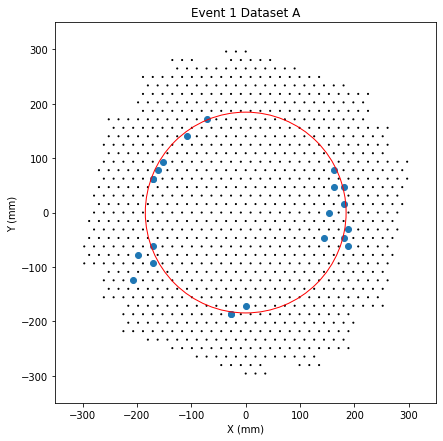

In [21]:
fig = plt.figure(figsize=(7, 7))
ax = fig.subplots()
ax.set_aspect('equal')
ax.set_xlim(-350,350) # mm
ax.set_ylim(-350,350) # mm
ax.set_xlabel('X (mm)')
ax.set_ylabel('Y (mm)')
ax.set_title(f'Event 1 Dataset A')

draw_pmt_pos(ax, position_map)
plt.scatter(hits[:, 0], hits[:, 1])
ax.add_artist(plt.Circle((0, 0), radius, fill=False,color="red"))
;

# Part 3: Combining all features

The features that we have can be described as follows:

| Name                  | Description                           | Notes                                                    | Located in                                                           |
|-----------------------|---------------------------------------|----------------------------------------------------------|----------------------------------------------------------------------|
| `run_id`              | The experiment run                    | Metadata                                                 | `HDF5["Events"]`                                                     |
| `burst_id`            | The particle burst                    | Metadata                                                 | `HDF5["Events"]`                                                     |
| `track_id`            | The particle track                    | Metadata                                                 | `HDF5["Events"]`                                                     |
| `track_momentum`      | Particle momentum                     | Single value                                             | `HDF5["Events"]`                                                     |
| `chod_time`           | Time recorded by CHOD detector        | Single value                                             | `HDF5["Events"]`                                                     |
| `ring_radius`         | Radius of fitted circle               | Single value                                             | `HDF5["Events"]`                                                     |
| `ring_centre_pos`     | Centre of fitted circle               | Array of two values: [x, y]                              | `HDF5["Events"]`                                                     |
| `ring_liklihood`      | Liklihood of three particles          | Array of three values: [particle1, particle2, particle3] | `HDF5["Events"]`                                                     |
| `disk_id`             | Used to locate hits with position map | Single value, input to `compute_seq_id`                  | `HDF5["Hits"]` indexed by `HDF5["HitMapping"]`                       |
| `pmt_id`              | Used to locate hits                   | Single value, input to `compute_seq_id`                  | `HDF5["Hits"]` indexed by `HDF5["HitMapping"]`                       |
| `supercell_id`        | Used to locate hits                   | Single value, input to `compute_seq_id`                  | `HDF5["Hits"]` indexed by `HDF5["HitMapping"]`                       |
| `updowndisk_id`       | Used to locate hits                   | Single value, input to `compute_seq_id`                  | `HDF5["Hits"]` indexed by `HDF5["HitMapping"]`                       |
| `hit_time`            | Time of each hit                      | Single value, but variable length for each event!        | `HDF5["Hits"]` indexed by `HDF5["HitMapping"]`                       |
| `hits (x, y, mirror)` | Actual coordinates and mirror hit     | Variable length for each event!                          | Get from `rich_pmt_positions.npy` with indices from `compute_seq_id` |

Now let's create input data for the very first example...

In [22]:
event = 0

## Data from `HDF5["Events"]`

In [23]:
event_features = {k:v for k, v in zip(f['Events'].dtype.names, f['Events'][event])}

In [24]:
event_features

{'run_id': 8548,
 'burst_id': 1095,
 'event_id': 11551,
 'track_id': 0,
 'track_momentum': 39.102062,
 'chod_time': 6.377106,
 'ring_radius': 184.68147,
 'ring_centre_pos': array([-196.52412 ,  -16.790398], dtype=float32),
 'ring_likelihood': array([5.2108949e-01, 1.0000000e+00, 3.3442233e-05], dtype=float32)}

## Hit data from `HDF5["Hits"]`, `HDF5["HitMapping"]`, and `rich_pmt_positions.npy`

In [25]:
# read in here again for clarity
position_map = np.load("/home/nico/RICHPID/tools/rich_pmt_positions.npy")
position_map.shape

(1952, 3)

In [26]:
hit_coords = []
hit_data = f['Hits'][f['HitMapping'][event]:f['HitMapping'][event+1]]
hit_times = hit_data["hit_time"]

for hit in hit_data:
    pm_idx = (
        compute_seq_id(
            disk_id=hit["disk_id"],
            up_dw_id=hit["updowndisk_id"],
            sc_id=hit["supercell_id"],
            pm_id=hit["pmt_id"]
        )
    )
    
    hit_coords.append(position_map[pm_idx])
    
hit_coords = np.array(hit_coords)
hit_coords_times = np.c_[hit_coords, hit_times]

```
array([[-171.       ,  -93.53     ,    1.       ,    6.4918146],
       [   0.       , -171.47     ,    1.       ,    6.334047 ],
       [ -27.       , -187.06     ,    1.       ,    6.0296416],  HIT TWICE
       [-153.       ,   93.53     ,    1.       ,    6.2478   ],
       [-162.       ,   77.94     ,    1.       ,    6.4438033],
       [-171.       ,   62.35     ,    1.       ,    6.271224 ],  HIT TWICE
       [ -72.       ,  171.47     ,    1.       ,  -28.139177 ],
       [ 189.       ,  -31.18     ,    1.       ,    6.3303947],
       [ 180.       ,   46.77     ,    1.       ,    6.297724 ],
       [ 180.       ,   15.59     ,    1.       ,    6.168077 ],
       [ 180.       ,  -46.77     ,    1.       ,    6.178306 ],
       [ 162.       ,   77.94     ,    1.       ,    6.3656635],
       [-171.       ,  -62.35     ,    1.       ,    7.366777 ],
       [-198.       ,  -77.94     ,    1.       ,    7.8246713],
       [-207.       , -124.71     ,    1.       ,    7.230756 ],
       [-108.       ,  140.3      ,    1.       ,  -27.836351 ],
       [ 189.       ,  -62.35     ,    1.       ,    6.2184596],
       [ 162.       ,   46.77     ,    1.       ,    5.7575994],
       [ 153.       ,    0.       ,    1.       ,    6.3124247],
       [ 144.       ,  -46.77     ,    1.       ,    6.40539  ],
       [-171.       ,   62.35     ,    1.       ,    5.7096343],  HIT TWICE
       [ -27.       , -187.06     ,    1.       ,    5.6795297]], HIT TWICE
```

### Hit times

- We need to deal with the variable number of hits, and hit times, for each event.
- Since we have 1,952 PM discs that can be hit by light, there are a max number of 1,952 hits that can occur for any event
- Therefore we could pad the `hit_times` so that the shape is `(1952, 1)` where the value in the vector is the time that that PM disc got hit
- May be tricky though if discs are getting hit twice...

In [27]:
hit_features = {}
total_pm_discs = position_map.shape[0]

# padded number of hit times
hit_times = np.pad(
    array=hit_times,
    pad_width=(0, total_pm_discs - hit_times.shape[0])
)

hit_features["hit_times"] = hit_times

print(hit_times)
print(hit_times.shape)

[6.4918146 6.334047  6.0296416 ... 0.        0.        0.       ]
(1952,)


### Hit locations - Option 1: Dictionary mapper

- We could create a unique dictionary mapper for each disc that contains the number of times it was hit
- But then we lose the time dimension

In [28]:
hit_dict = {tuple(k):0 for k in position_map}
len(hit_dict)

1952

In [29]:
for coords in hit_coords:
    hit_dict[tuple(coords)] += 1

In [30]:
for coord, hit in hit_dict.items():
    if hit > 0:
        print(f"Disc: {coord} \t hits: {hit}")

Disc: (-171.0, 62.35, 1.0) 	 hits: 2
Disc: (-162.0, 77.94, 1.0) 	 hits: 1
Disc: (-153.0, 93.53, 1.0) 	 hits: 1
Disc: (144.0, -46.77, 1.0) 	 hits: 1
Disc: (180.0, -46.77, 1.0) 	 hits: 1
Disc: (189.0, -62.35, 1.0) 	 hits: 1
Disc: (189.0, -31.18, 1.0) 	 hits: 1
Disc: (153.0, 0.0, 1.0) 	 hits: 1
Disc: (180.0, 15.59, 1.0) 	 hits: 1
Disc: (-108.0, 140.3, 1.0) 	 hits: 1
Disc: (-72.0, 171.47, 1.0) 	 hits: 1
Disc: (162.0, 46.77, 1.0) 	 hits: 1
Disc: (180.0, 46.77, 1.0) 	 hits: 1
Disc: (162.0, 77.94, 1.0) 	 hits: 1
Disc: (-198.0, -77.94, 1.0) 	 hits: 1
Disc: (-171.0, -62.35, 1.0) 	 hits: 1
Disc: (-207.0, -124.71, 1.0) 	 hits: 1
Disc: (-171.0, -93.53, 1.0) 	 hits: 1
Disc: (-27.0, -187.06, 1.0) 	 hits: 2
Disc: (0.0, -171.47, 1.0) 	 hits: 1


### Hit locations - Option 2: Pandas DataFrame

- For the `(x, y)` hits, we can try creating a 2D array of shape `(1952, 1952)` with boolean values that represent whether or not this PM disc was hit
- We can see below that the `x` values go from `-297` to `297` and the `y` values from `-296` to `296`

In [31]:
print(f"Smallest (x, y): ({min(position_map[:, :1])[0]}, {min(position_map[:, 1:2])[0]})")
print(f"Largest (x, y): ({max(position_map[:, :1])[0]}, {max(position_map[:, 1:2])[0]})")

Smallest (x, y): (-297.0, -296.17999267578125)
Largest (x, y): (297.0, 296.17999267578125)


In [32]:
x_coords = set(position_map[:, :1].flatten())    # all the unique x coordinates
y_coords = set(position_map[:, 1:2].flatten())   # all the unique y coordinates

In [33]:
# now this is an array of all the pm discs with boolean hit/not hit values
pm_hit_locations = pd.DataFrame(np.zeros((len(y_coords), len(x_coords))), index=y_coords, columns=x_coords)
pm_hit_locations = pm_hit_locations.sort_index().sort_index(axis=1)
pm_hit_locations

,-297.0,-288.0,-279.0,-270.0,-261.0,-252.0,-243.0,-234.0,-225.0,-216.0,...,216.0,225.0,234.0,243.0,252.0,261.0,270.0,279.0,288.0,297.0
-296.179993,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-280.589996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-265.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-249.419998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-233.830002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-218.240005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-202.649994,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-187.059998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-171.470001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-155.880005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
for hit in hit_coords:
    pm_hit_locations.at[hit[1], hit[0]] += 1

In [35]:
pm_hit_locations.sum().sum() == len(hit_coords)

True